In [66]:
using PyPlot,JLD2,CALCEPH

Using $\sqrt{e} \cos{\omega}$ and $\sqrt{e} \sin{\omega}$ as priors, doesnt work properly. don't know why. Reverted to previous prior $e \cos{\omega}$ and $e \sin{\omega}$

In [187]:
calc_deg(value) = value * 180/pi
calc_rad(value) = value * pi/180
function extract_data(filename)
	f = jldopen(String(filename), "r")
	return f["pbest_global"]
end
function evec(ecc,om)
    omega = calc_rad(om)
    ecosw = ecc*cos(omega)
    esinw = ecc*sin(omega)
    return ecosw,esinw
end

evec (generic function with 1 method)

In [202]:
mu_1,P_1,t01,e1cosw1,e1sinw1,
mu_2,P_2,t02,e2cosw2,e2sinw2,
mu_3,P_3,t03,e3cosw3,e3sinw3,
tmaxsinphi0,tmaxcosphi0,deltaphi = extract_data("OUTPUTS/moon_fittry1params.jld2")

18-element Array{Float64,1}:
    2.5275788989834023e-6
  224.70077098675895     
    2.433503768851615e6  
    0.00285673419852034  
    0.0007550609482464021
    3.04375001408466e-6  
  365.25646214139175     
    2.433624407402546e6  
    0.015037015083073492 
    0.0029763518560029555
    0.000941720902889919 
 4309.232984673987       
    2.443388213396815e6  
    0.02441377873531106  
   -0.03777031122605469  
    9.295524225689489e-5 
   -0.0016399728262300934
    2.312317961379825    

In [203]:
@load("NYR40/moon_try1mcmc.jld2")

8-element Array{Symbol,1}:
 :par_mcmc    
 :lprob_mcmc  
 :param       
 :nwalkers    
 :nsteps      
 :accept      
 :iburn       
 :indepsamples

In [11]:
include("decompose_ttvs.jl")
include("plot_ttvs.jl")
include("plot_likelihood.jl")
include("corner_plot.jl")

corner_planet (generic function with 1 method)

In [193]:
evec(0.00677323,131.53298)

(-0.004490997226230397, 0.005070265135758768)

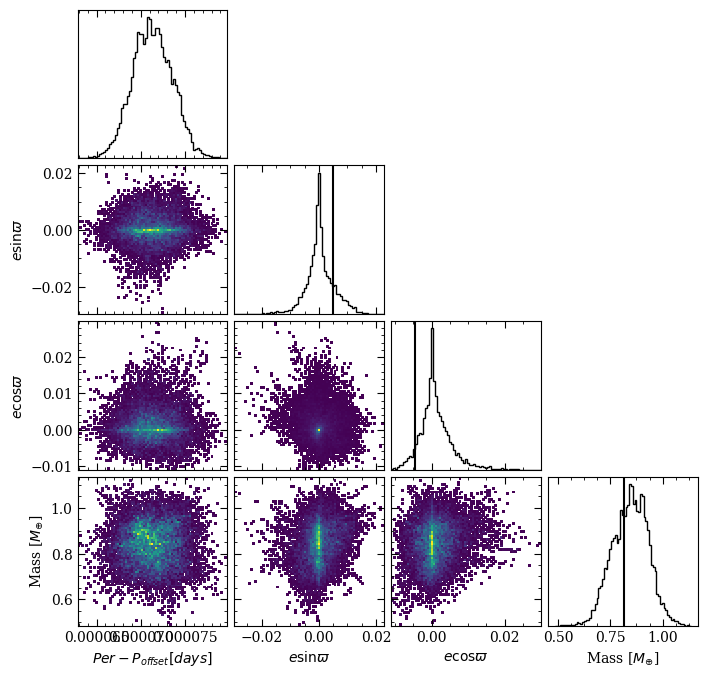

In [213]:
corner_planet(vec(par_mcmc[1:10,iburn:nsteps,1]).* CGS.MSUN/CGS.MEARTH,
    (vec(par_mcmc[1:10,iburn:nsteps,4]).*sqrt.(vec(par_mcmc[1:10,iburn:nsteps,4]).^2 .+ vec(par_mcmc[1:10,iburn:nsteps,5]).^2)),
    (vec(par_mcmc[1:10,iburn:nsteps,5]).*sqrt.(vec(par_mcmc[1:10,iburn:nsteps,4]).^2 .+ vec(par_mcmc[1:10,iburn:nsteps,5]).^2)),
    vec(par_mcmc[1:10,iburn:nsteps,2]),75,
0.815,-0.0044,0.0051,224.7007992,"venus")

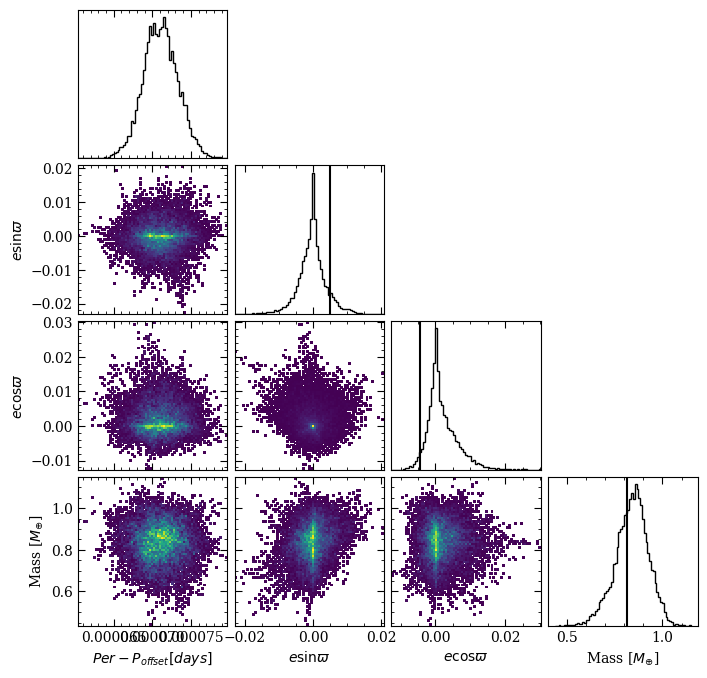

In [214]:
corner_planet(vec(par_mcmc[11:20,iburn:nsteps,1]).* CGS.MSUN/CGS.MEARTH,
    (vec(par_mcmc[11:20,iburn:nsteps,4]).*sqrt.(vec(par_mcmc[11:20,iburn:nsteps,4]).^2 .+ vec(par_mcmc[11:20,iburn:nsteps,5]).^2)),
    (vec(par_mcmc[11:20,iburn:nsteps,5]).*sqrt.(vec(par_mcmc[11:20,iburn:nsteps,4]).^2 .+ vec(par_mcmc[11:20,iburn:nsteps,5]).^2)),
    vec(par_mcmc[11:20,iburn:nsteps,2]),75,
0.815,-0.0044,0.0051,224.7007992,"venus")

In [ ]:
corner_planet(vec(par_mcmc[1:10,iburn:nsteps,1]).* CGS.MSUN/CGS.MEARTH,
    (vec(par_mcmc[1:10,iburn:nsteps,4]).*sqrt.(vec(par_mcmc[1:10,iburn:nsteps,4]).^2 .+ vec(par_mcmc[1:10,iburn:nsteps,5]).^2)),
    (vec(par_mcmc[1:10,iburn:nsteps,5]).*sqrt.(vec(par_mcmc[1:10,iburn:nsteps,4]).^2 .+ vec(par_mcmc[1:10,iburn:nsteps,5]).^2)),
    vec(par_mcmc[1:10,iburn:nsteps,2]),75,
0.815,-0.0044,0.0051,224.7007992,"venus")

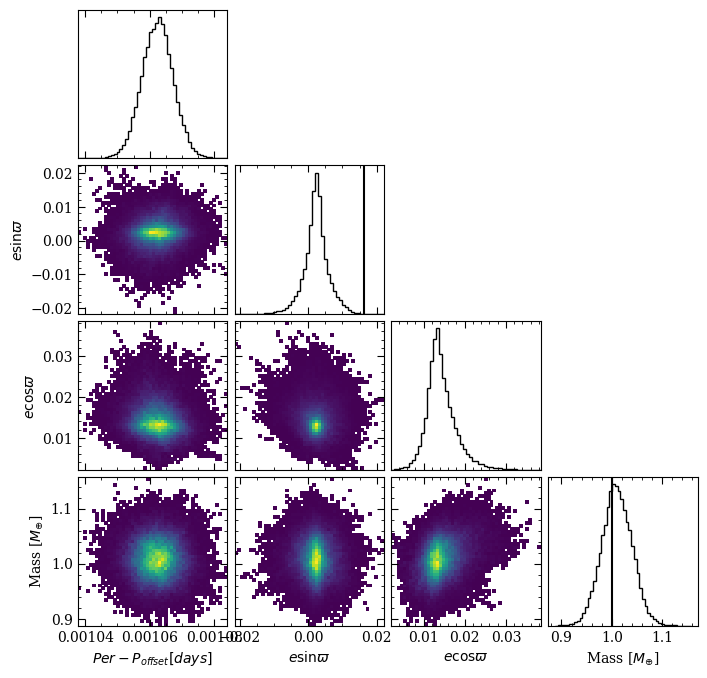

In [207]:
corner_planet(vec(par_mcmc[:,1:nsteps,6]).* CGS.MSUN/CGS.MEARTH,
    (vec(par_mcmc[:,1:nsteps,9]).*sqrt.(vec(par_mcmc[:,1:nsteps,9]).^2 .+ vec(par_mcmc[:,1:nsteps,10]).^2)),
    (vec(par_mcmc[:,1:nsteps,10]).*sqrt.(vec(par_mcmc[:,1:nsteps,9]).^2 .+ vec(par_mcmc[:,1:nsteps,10]).^2)),
    vec(par_mcmc[:,1:nsteps,7]),50,
1,-0.00374,0.016285,365.2564,"earth")

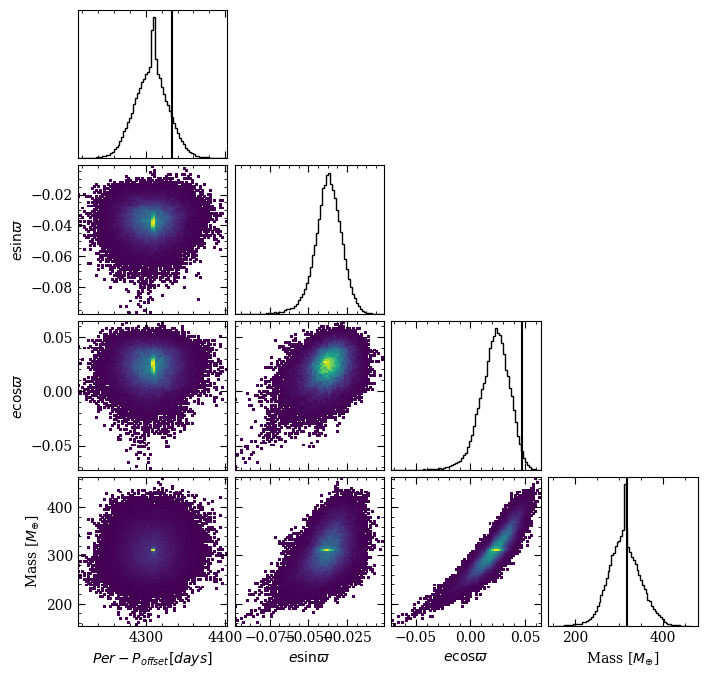

In [206]:
corner_planet(vec(par_mcmc[:,1:nsteps,11]).* CGS.MSUN/CGS.MEARTH,
     (vec(par_mcmc[:,1:nsteps,14]).*sqrt.(vec(par_mcmc[:,1:nsteps,14]).^2 .+ vec(par_mcmc[:,1:nsteps,15]).^2)),
   (vec(par_mcmc[:,1:nsteps,15]).*sqrt.(vec(par_mcmc[:,1:nsteps,14]).^2 .+ vec(par_mcmc[:,1:nsteps,15]).^2)),
    vec(par_mcmc[:,1:nsteps,12]),75,
318,0.0468,0.0123,4332.82012875,"jup")

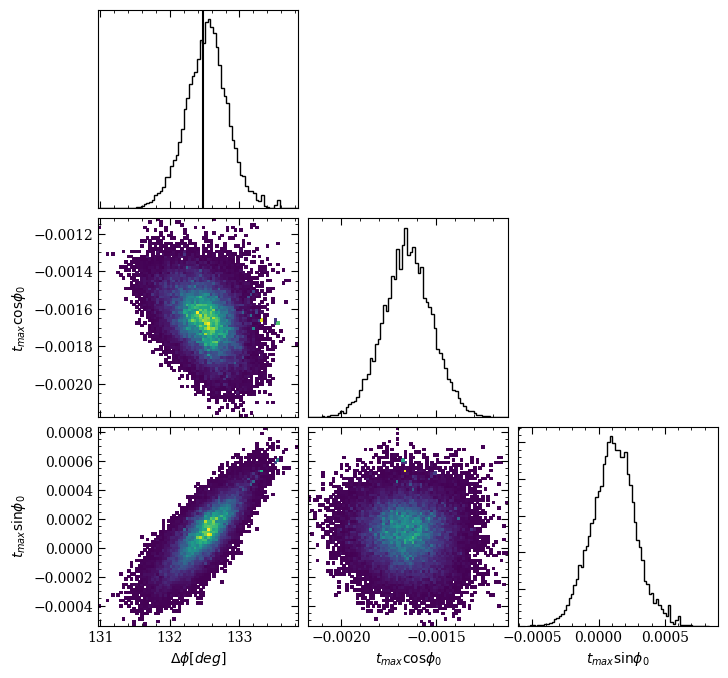

In [174]:
corner_moon(vec(par_mcmc[:,iburn:nsteps,16]),
    vec(par_mcmc[:,iburn:nsteps,17]),
    vec(par_mcmc[:,iburn:nsteps,18]).*57.2957795,75,
 0.00001,0.00001,2.3122.*57.2957795,"moon")

Using original prior on eccentricity.

In [183]:
mu_1,P_1,t01,e1cosw1,e1sinw1,
mu_2,P_2,t02,e2cosw2,e2sinw2,
mu_3,P_3,t03,e3cosw3,e3sinw3,
tmaxsinphi0,tmaxcosphi0,deltaphi = extract_data("OUTPUTS/moon_fitmtry3params.jld2")
@load("mcmc_mtry3results.jld2")

8-element Array{Symbol,1}:
 :par_mcmc    
 :lprob_mcmc  
 :param       
 :nwalkers    
 :nsteps      
 :accept      
 :iburn       
 :indepsamples

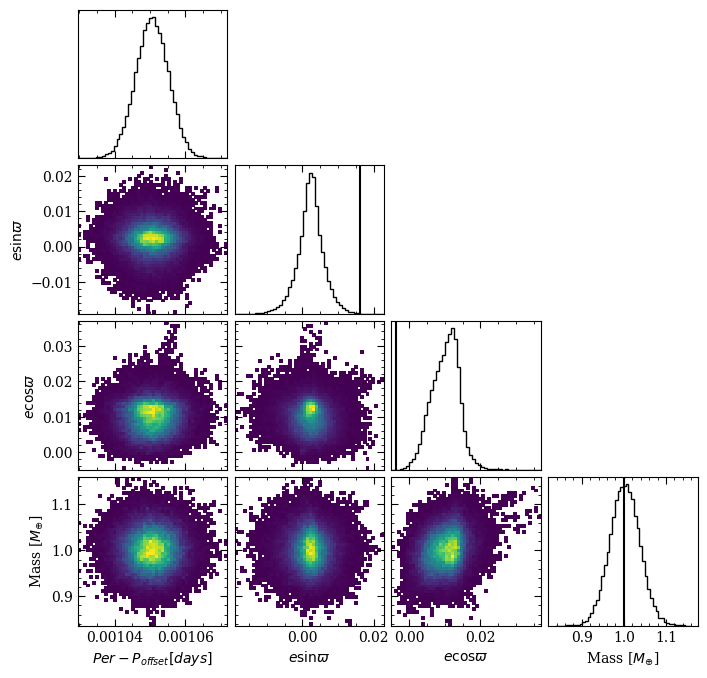

In [190]:
corner_planet(vec(par_mcmc[:,iburn:nsteps,6]).* CGS.MSUN/CGS.MEARTH,
    vec(par_mcmc[:,iburn:nsteps,9]),
    vec(par_mcmc[:,iburn:nsteps,10]),
    vec(par_mcmc[:,iburn:nsteps,7]),50,
1,-0.00374,0.016285,365.2564,"earth")

In [188]:
evec(0.01671022,102.94719)

(-0.0037439728139313944, 0.016285395912195154)

In [186]:
cos(pi)

-1.0

In [5]:
f = jldopen("FITS/p3_fit30.0s40.0yrs.jld2","r")

JLDFile /Users/bethleelindor/work/washington/ttv_project/ttv_ss/FITS/p3_fit30.0s40.0yrs.jld2 (read-only)
 ├─🔢 param_p3
 ├─🔢 lprob_p3
 ├─🔢 lprob_best
 ├─🔢 pbest_global
 ├─🔢 ntrans
 ├─🔢 nplanet
 ├─🔢 tt0
 ├─🔢 tt
 ├─🔢 ttmodel
 ├─🔢 sigtt
 ├─🔢 p3in
 ├─🔢 p3out
 ├─🔢 np3
 └─🔢 nphase

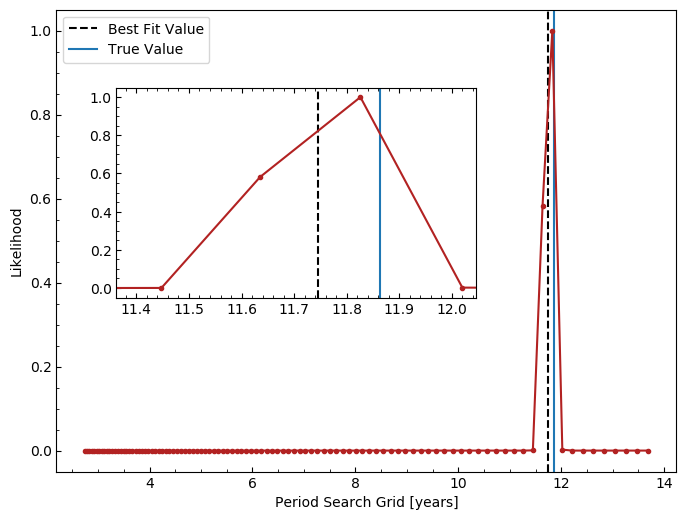

In [107]:
include("plot_likelihood.jl")
plot_likelihood(f,false)

In [110]:
4319/364.25

11.857240905971175

In [111]:
p3_cur = 11.86*365.25

4331.865

In [128]:
f["param_p3"][:,end-9]

15-element Array{Float64,1}:
    2.3446614129896373e-6
  224.70077136301376     
    2.4335037655088506e6 
    0.0036331894613460484
    0.0009173470516518066
    3.0373264070536543e-6
  365.25646505841814     
    2.433624402036106e6  
    0.01532911035246307  
    0.0036248909237146204
    0.001005372082385185 
 4319.438318512952       
    2.443433612019112e6  
    0.03349064076111956  
   -0.03220506232149059  

Q: when we talk about goodness of fit, we're comparing the "best" fit to the true value (or another model, if available) but we can only characterize the best fit value by the MCMC sampling, correct? So when showing the likelihoods, which value is preferred?

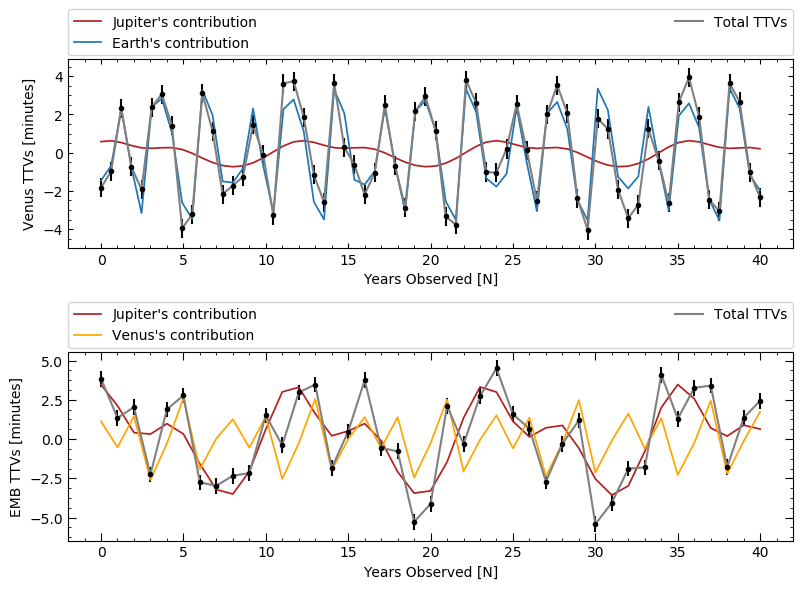

In [109]:
include("plot_ttvs.jl")
plot_ttvs(f)
# savefig("IMAGES/EMBttvs.eps")

In [ ]:
include("plot_orbits.jl")